# Step 4: Reconstruction

## a) Reconstruct

In [1]:
distances = [15, 35]
doubleplanes = [8, 12, 20, 30]
energies = [200, 600, 1000]
erels = [100, 500, 1000, 2000, 3000]
neutrons = [1, 2, 3, 4, 5, 6]
physicss = ["bert", "bic", "inclxx"]

In [2]:
import joblib
from reconstruction import reconstruction

joblib.Parallel(n_jobs=-1, backend="loky", verbose=1)(
    joblib.delayed(reconstruction)(
        distance=distance, doubleplane=doubleplane, energy=energy, erel=erel, neutron=neutron, physics=physics,
    )
    for distance in distances
    for energy in energies
    for doubleplane in doubleplanes
    for neutron in neutrons
    for erel in erels
    for physics in physicss
)

print("Done")

Welcome to JupyROOT 6.16/00


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1138 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 43.5min finished


Done


## b) Inspect example file

In [3]:
from helpers import filename_for
import pandas as pd
import numpy as np
import ROOT

In [4]:
distance = 35
doubleplane = 30
energy = 600
erel = 100
neutron = 1
physics = "inclxx"

In [5]:
fn = filename_for(distance, doubleplane, energy, erel, neutron, physics, ".reco.root")
f = ROOT.TFile.Open(fn)
f.cd("NeulandNeutronReconstructionMon")
f.ls()

TFile**		output/inclxx/35m_30dp_600AMeV_100keV_1n.reco.root	
 TFile*		output/inclxx/35m_30dp_600AMeV_100keV_1n.reco.root	
  TDirectoryFile*		NeulandNeutronReconstructionMon	NeulandNeutronReconstructionMon
   KEY: TH1D	fhCountN;2	Number of reconstructed Neutrons
   KEY: TH1D	fhCountN;1	Number of reconstructed Neutrons
   KEY: TH1D	fhCountNdiff;2	Number of reacted primary Neutrons - Number of reconstructed Neutrons
   KEY: TH1D	fhCountNdiff;1	Number of reacted primary Neutrons - Number of reconstructed Neutrons
   KEY: TH1D	fhScore;2	Neuland Neutron Reconstruction Score (lower is better)
   KEY: TH1D	fhScore;1	Neuland Neutron Reconstruction Score (lower is better)
   KEY: TH1D	fhEdiff;2	Energy of primary Neutron - Energy of reconstructed Neutron
   KEY: TH1D	fhEdiff;1	Energy of primary Neutron - Energy of reconstructed Neutron
   KEY: TH1D	fhErel;2	fhErel
   KEY: TH1D	fhErel;1	fhErel
   KEY: TH1D	fhErelMC;2	fhErelMC
   KEY: TH1D	fhErelMC;1	fhErelMC
   KEY: TH2D	fhErelVSnNreco;2	fhErelVSn

Workaround for jupyter lab until up-to-date ROOT version is in FairRoot

In [6]:
%%javascript
var s = document.createElement('script');
s.src='https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js';
document.body.appendChild(s);

<IPython.core.display.Javascript object>

In [7]:
%jsroot on
c1 = ROOT.TCanvas("c1", "c1", 800, 600)
h1 = f.Get("NeulandNeutronReconstructionMon/fhErel1")
h1.Draw()
c1.Draw()

In [8]:
%jsroot on
c2 = ROOT.TCanvas("c2", "c2", 800, 600)
h2 = f.Get("NeulandNeutronReconstructionMon/fhErelMC")
h2.Draw()
c2.Draw()

## c) Plot example spectrum with rootpy and matplotlib

In [9]:
from plotconfroot import *
from helpers import filename_for

In [10]:
def fit_n_plot(ax, xmin, xmax, hist):
    fitresult = hist.Fit("gaus", "S", "", xmin, xmax)
    fun = fitresult.FittedFunction().GetFunction()
    xs = np.arange(xmin, xmax, 1)
    ys = [fun.Eval(x) for x in xs]

    ax.set_xlim(0, erel * 3)
    rplt.step(hist, axes=ax, color="black")
    ax.plot(xs, ys, color="red")
    ax.text(
        0.98,
        0.9,
        fr"$\sigma$ = {round(fitresult.GetParams()[2])} keV",
        horizontalalignment="right",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize=25,
    )

    twosigintegral = hist.Integral(
        hist.FindBin(fitresult.GetParams()[1] - 2 * fitresult.GetParams()[2]),
        hist.FindBin(fitresult.GetParams()[1] + 2 * fitresult.GetParams()[2]),
    )
    print(twosigintegral, hist.GetEntries(), twosigintegral / hist.GetEntries())

    return fitresult.GetParams()[2]

Using matplotlib backend: agg
7276.0 9005.0 0.8079955580233203


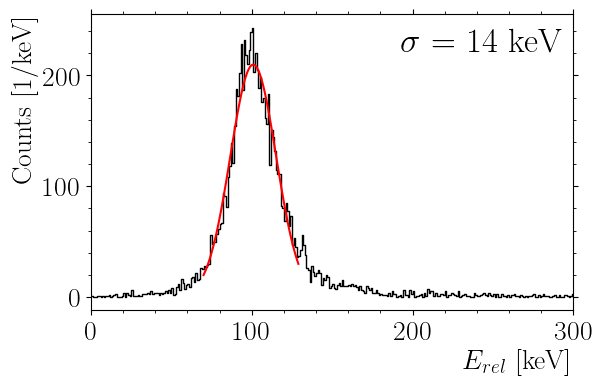

 FCN=111.32 FROM MIGRAD    STATUS=CONVERGED      62 CALLS          63 TOTAL
                     EDM=1.16467e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.09791e+02   3.32716e+00   1.27769e-02   1.68348e-05
   2  Mean         1.00911e+02   1.87838e-01   9.62826e-04  -7.54396e-07
   3  Sigma        1.42326e+01   1.87031e-01   1.76915e-05  -2.35792e-02


In [11]:
%matplotlib

distance = 35
doubleplane = 30
energy = 600
erel = 100
neutron = 1
physics = "inclxx"

fn = filename_for(distance, doubleplane, energy, erel, neutron, physics, ".reco.root")
file = rootpy.io.root_open(fn, "read")
herel = file.Get(f"NeulandNeutronReconstructionMon/fhErel{neutron}")

fig = plt.figure(figsize=(6.224, 6.224 / 1.618))
ax = fig.add_subplot(111)
fit_n_plot(ax, 70, 130, herel)
ax.set_xlabel(r"$E_{rel}$ [keV]", horizontalalignment="right", x=1)
ax.set_ylabel(r"Counts [1/keV]", horizontalalignment="right", y=1)
fig.savefig(f"results/erel-{neutron}n-{erel}.pdf", bbox_inches="tight")
display(fig)

Using matplotlib backend: agg
2420.0 4756.0 0.5088309503784693


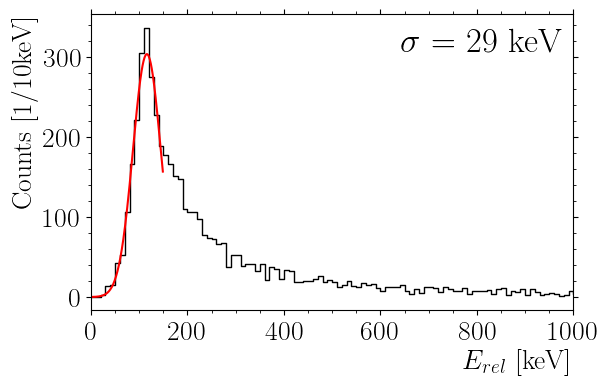

 FCN=17.4396 FROM MIGRAD    STATUS=CONVERGED      71 CALLS          72 TOTAL
                     EDM=1.07079e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.04043e+02   8.74082e+00   1.44839e-02  -5.70929e-05
   2  Mean         1.15884e+02   1.03722e+00   1.60928e-03  -3.66843e-05
   3  Sigma        2.88029e+01   8.57987e-01   1.42677e-05  -5.60282e-03


In [12]:
%matplotlib

distance = 35
doubleplane = 30
energy = 600
erel = 100
neutron = 4
physics = "inclxx"

fn = filename_for(distance, doubleplane, energy, erel, neutron, physics, ".reco.root")
file = rootpy.io.root_open(fn, "read")
herel = file.Get(f"NeulandNeutronReconstructionMon/fhErel{neutron}")
herel.rebin(10)

fig = plt.figure(figsize=(6.224, 6.224 / 1.618))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$E_{rel}$ [keV]", horizontalalignment="right", x=1)
ax.set_ylabel(r"Counts [1/10keV]", horizontalalignment="right", y=1)
fit_n_plot(ax, 0, 150, herel)
ax.set_xlim(0, 1000)
fig.savefig(f"results/erel-{neutron}n-{erel}.pdf", bbox_inches="tight")
display(fig)

## d) Resolution as a function of relative energy for both distances

Using matplotlib backend: agg
7852.0 9357.0 0.839157849738164
7424.0 9324.0 0.7962247962247962
7348.0 9327.0 0.7878203066366463
7494.0 9268.0 0.8085886922744929
7404.0 9219.0 0.803123983078425
7540.0 9005.0 0.8373126041088285
7240.0 8925.0 0.8112044817927171
7145.0 8692.0 0.8220202485043718
3399.0 3989.0 0.8520932564552519
1972.0 2311.0 0.8533102553007356


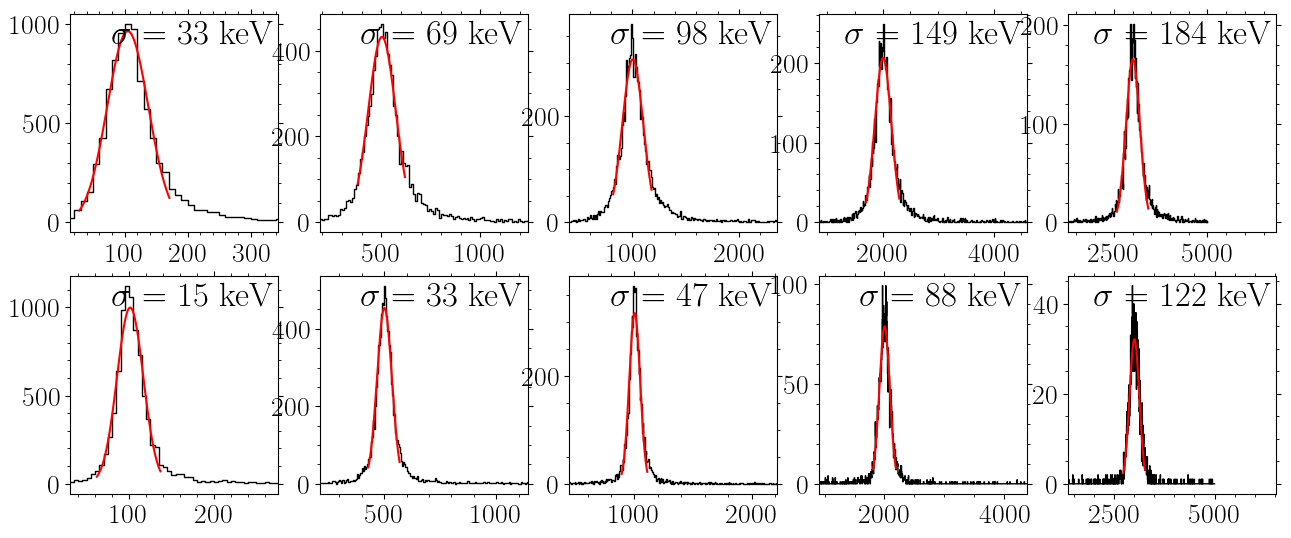

 FCN=56.204 FROM MIGRAD    STATUS=CONVERGED      58 CALLS          59 TOTAL
                     EDM=1.06049e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     9.65322e+02   1.47583e+01   4.08357e-02   6.55862e-05
   2  Mean         1.04919e+02   4.23434e-01   1.52068e-03  -1.56596e-03
   3  Sigma        3.25858e+01   4.04702e-01   1.18394e-05  -6.96625e-02
 FCN=47.349 FROM MIGRAD    STATUS=CONVERGED      73 CALLS          74 TOTAL
                     EDM=7.75481e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.31739e+02   7.21114e+00   1.76931e-02   1.05345e-05
   2  Mean         5.02971e+02   1.02325e+00   3.47358e-03  -8.83085e-05
   3  Sigma        6.91350e+01   1.

In [13]:
%matplotlib

jobs = [
    (distance, doubleplane, energy, erel, neutron)
    for distance in [15, 35]
    for doubleplane in [30]
    for energy in [600]
    for erel in [100, 500, 1000, 2000, 3000]
    for neutron in [1]
]

fig = plt.figure(figsize=(6.224 * 2.5, 6.224))
tmp = []
for i, job in enumerate(jobs):
    fn = filename_for(job[0], job[1], job[2], job[3], job[4], "inclxx", ".reco.root")
    file = rootpy.io.root_open(fn, "read")
    hist = file.Get(f"NeulandNeutronReconstructionMon/fhErel{job[4]}")

    if job[0] == 15:
        hist.rebin(10)
        xmin = 0.88 * job[3] - 60
        xmax = 1.12 * job[3] + 60
    else:
        hist.rebin(5)
        xmin = 0.92 * job[3] - 30
        xmax = 1.08 * job[3] + 30

    ax = fig.add_subplot(2, 5, i + 1)
    erel = fit_n_plot(ax, xmin, xmax, hist)

    ax.set_xlim(0.5 * xmin, 2 * xmax)

    tmp.append([*job, erel])

data = pd.DataFrame(tmp)
data.columns = ["distance", "doubleplane", "energy", "erel", "neutron", "sigma"]

display(fig)

In [14]:
display(data)

,distance,doubleplane,energy,erel,neutron,sigma
0,15,30,600,100,1,32.585766
1,15,30,600,500,1,69.135034
2,15,30,600,1000,1,97.877955
3,15,30,600,2000,1,149.057398
4,15,30,600,3000,1,184.354644
5,35,30,600,100,1,15.488741
6,35,30,600,500,1,32.926171
7,35,30,600,1000,1,46.565566
8,35,30,600,2000,1,87.620814
9,35,30,600,3000,1,121.574189


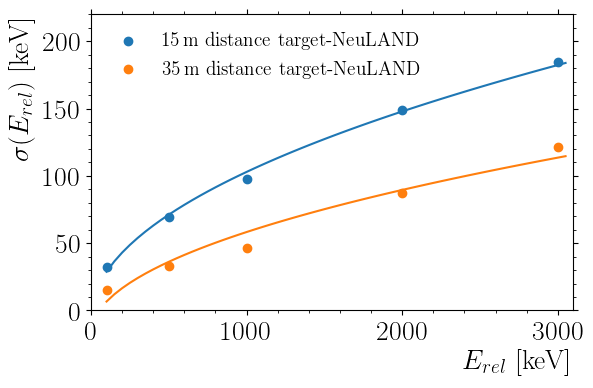

In [15]:
import scipy.optimize

fig = plt.figure(figsize=(6.224, 6.224 / 1.618))
ax = fig.add_subplot(111)
ax.set_xlim(0, 3100)
ax.set_xlabel(r"$E_{rel}$ [keV]", horizontalalignment="right", x=1)
ax.set_ylim(0, 220)
ax.set_ylabel(r"$\sigma(E_{rel})$ [keV]", horizontalalignment="right", y=1)


def func(x, a, b):
    return a * np.sqrt(x) + b


for distance in [15, 35]:
    tmp = data.loc[data["distance"] == distance]
    ax.scatter(
        tmp["erel"].values, tmp["sigma"].values, label=f"{distance}\,m distance target-NeuLAND",
    )

    fito, fitc = scipy.optimize.curve_fit(func, tmp["erel"].values, tmp["sigma"].values)
    xs = np.arange(100, 3100, 50)
    ys = func(xs, *fito)
    ax.plot(xs, ys)

ax.legend(loc="upper left", prop={"size": "x-small"})
fig.savefig("results/sigma.pdf", bbox_inches="tight")
display(fig)

## e) Other values

Basic efficiency

In [16]:
for doubleplane in doubleplanes:
    for energy in energies:
        fn = filename_for(
            distance=15,
            doubleplane=doubleplane,
            energy=energy,
            erel=500,
            neutron=1,
            physics="inclxx",
            what=".digi.root",
        )
        file = ROOT.TFile.Open(fn)
        hist = file.Get("NeulandPrimaryClusterMon/nClusters")
        primclus = [hist.GetBinContent(i) for i in range(1, 7)]
        print(doubleplane, energy, primclus[1] / hist.GetEntries())

8 200 0.5685
8 600 0.6079
8 1000 0.6484
12 200 0.7117
12 600 0.7559
12 1000 0.7888
20 200 0.8679
20 600 0.8929
20 1000 0.9092
30 200 0.9319
30 600 0.9481
30 1000 0.9575


Count number of events where a primary neutron undergoes a reaction before entering NeuLAND

In [17]:
hists = []
tmpprereac = []
for energy in energies:
    for distance in [15, 35]:
        for neutron in [1, 4]:
            for physics in ["inclxx", "bic", "bert"]:
                fn = filename_for(
                    distance=distance,
                    doubleplane=30,
                    energy=energy,
                    erel=500,
                    neutron=neutron,
                    physics=physics,
                    what=".simu.root",
                )
                f = ROOT.TFile.Open(fn)
                primary_neutron_track_ids = range(1, neutron + 1)

                zse = []
                for e in f.evt:
                    zs = []
                    for i, track in enumerate(e.MCTrack):
                        if track.GetStartZ() < 1500 and track.GetMotherId() in primary_neutron_track_ids:
                            # print(all, i, track.GetMotherId(), track.GetPdgCode())
                            zs.append(track.GetStartZ())
                    if len(zs) > 0:
                        zse.append(zs)

                tmpprereac.append((energy, distance, neutron, physics, len(zse), len(zse) / f.evt.GetEntries()))
                flatten = lambda l: [item for sublist in l for item in sublist]
                hist = np.histogram(flatten(zse), range=(0, 1500), bins=1500)
                hists.append(hist)

In [18]:
prereac = pd.DataFrame(tmpprereac)
prereac.columns = ["energy", "distance", "neutron", "physics", "evts", "frac"]
display(prereac[(prereac["physics"] == "inclxx") & (prereac["distance"] == 15)])

,energy,distance,neutron,physics,evts,frac
0,200,15,1,inclxx,351,0.0351
3,200,15,4,inclxx,1440,0.1440
12,600,15,1,inclxx,406,0.0406
15,600,15,4,inclxx,1441,0.1441
24,1000,15,1,inclxx,428,0.0428
27,1000,15,4,inclxx,1580,0.1580


Using matplotlib backend: agg


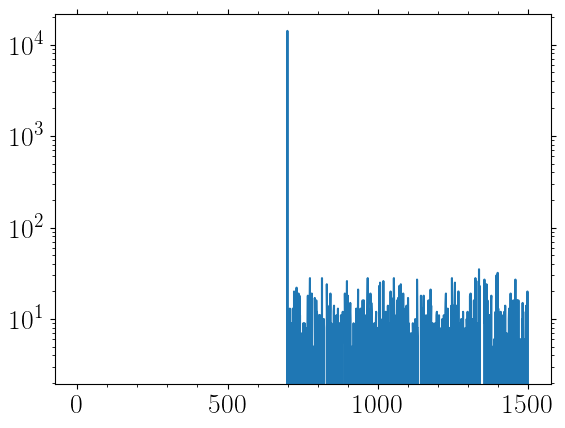

In [19]:
%matplotlib
fig = plt.Figure()
ax = fig.add_subplot(111)
xs = np.arange(0, 1500)
ax.plot(xs, hist[0])
ax.set_yscale("log")
display(fig)